### This code models the daily vertical migration of aquatic animals in a water body with an uneven bed.

In [54]:
#################

## imports 

#################

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.misc import derivative
from matplotlib import animation
#from matplotlib import colors

%matplotlib notebook

In [66]:
################
# function to return lakebed y for given x
def lakebed(x):
    return(depth_of_water_column - 
              amplitude_sin*np.sin(2*np.pi*x*frequency_sin/width) - 
              amplitude_cos*np.cos(x*frequency_cos))

################
#return slope of line of path of individual
def path_slope(x1,y1,x2,y2):
    if x1 == x2:
        return(np.inf)
    else:
        return((y2-y1)/(x2-x1))

################
#return intercept of line of path of individual
def path_intercept(x1,y1,x2,y2):
    c = y2 - x2*path_slope(x1,y1,x2,y2)
    return(c)
    
################
#for given x, return y of path of individual
def intersection_function(x):
    h = lakebed(x) - path_function(x)
    return(h)


################
#calculate point of intersection between lakebed and path
def intersection_point_lakebed(x1,y1,x2,y2):
    if x1 == x2: #slope is inf
        x_int = x1
        y_int = lakebed(x_int)
    else:
        x_int = scipy.optimize.fsolve(intersection_function, x2)
        y_int = path_function(x_int)
    return(x_int,y_int)


################
#calculate point of intersection between water surface and path
def intersection_point_water(x1,y1,x2,y2):
    if x1 == x2:
        x_int = x1
    else:
        m = path_slope(x1,y1,x2,y2)
        x_int = x2 - y2/m
    y_int = 0
    return(x_int,y_int)

################
#for given x, return y of path of individual
def path_function(x):
    m = path_slope(x1,y1,x2,y2)
    c = path_intercept(x1,y1,x2,y2)
    return(m*x + c)


#################
# function to check if path intersects with water
def intersect_water(x,y):
    if y < 0:
        return(True)
    else:
        return(False)

    
#################
# function to check if path intersects with lake bed
def intersect_lakebed(x,y):
    if y > lakebed(x):
        return(True)
    else:
        return(False)
    
#################
# function to return final x and y coods of individual reflected off surface of water
def reflect_water(x1,y1,x2,y2):
    x_ref = x2
    y_ref = -y2
    return(x_ref,y_ref)

#################
# function to return final x and y coods of individual reflected off surface of lake bed
def reflect_lakebed(x1,y1,x2,y2):
    if x1 == x2:
        angle2 = 90*np.pi/180
    else:
        slope = path_slope(x1,y1,x2,y2)
        angle2 = np.arctan(slope)
        
    x_int, y_int = intersection_point_lakebed(x1,y1,x2,y2)
    distance = np.sqrt((x_int - x1)**2 + (y_int - y1)**2)
    angle2 = np.arctan(derivative(lakebed,x_int))
    x_ref = (step_length-distance)*np.cos(angle2)%width
    y_ref = (step_length-distance)*np.sin(angle2)
    return(x_ref,y_ref)


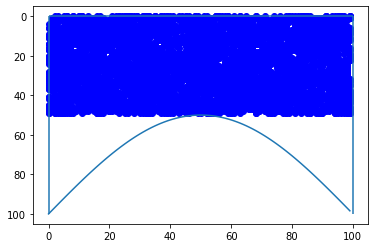

In [51]:



#################

## parameters

#################

num_animals = 5000
max_time_steps = 10
amplitude_sin = 50
amplitude_cos = 0
frequency_sin = 0.5
frequency_cos = 0
preferred_depth = 5
depth_of_water_column = 100 #>> amplitude
width = 100
x_over_time = np.zeros((num_animals,max_time_steps))
y_over_time = np.zeros((num_animals,max_time_steps))
step_length = 1
strength_of_attraction = 2
strength_of_lake_bed_reflection = 0.5 #0 (move along lake bed) to 1
sigma = 10 #degrees - inverse of measure of correlation
theta_initial = np.random.uniform(0,360,size = (num_animals,1))

#################

## plot water body

#################

#function to accept amplitude, frequency, depth of water column and plot water body to check

lake_bed_x = np.arange(0,width,width/100)
lake_bed_y = (depth_of_water_column - 
              amplitude_sin*np.sin(2*np.pi*lake_bed_x*frequency_sin/width) - 
              amplitude_cos*np.cos(lake_bed_x*frequency_cos)) #+ 2*np.max((amplitude_cos,amplitude_sin))
plt.figure()
plt.plot(lake_bed_x,lake_bed_y)

plt.hlines(depth_of_water_column,0,width)
plt.vlines(0,0,depth_of_water_column)
plt.vlines(width,0,depth_of_water_column)



#################

## initialise

#################

#give random locations (x and y) to all animals

x = np.random.choice(width,(num_animals))
y = np.random.choice(int(np.floor(depth_of_water_column-max(amplitude_sin,amplitude_cos))),(num_animals))


plt.close('all')
plt.figure()
plt.plot(lake_bed_x,lake_bed_y)
plt.scatter(x, y, color = "blue")
plt.hlines(0,0,width)
plt.vlines(0,0,depth_of_water_column)
plt.vlines(width,0,depth_of_water_column)
ax = plt.gca()
ax.invert_yaxis()
plt.show()



#################

## update function

#################

#function to apply correlated random walk to animals with attraction to preferred depth and apply rules
def move(x,y, theta_previous):
    

    #choose direction in which to move (correlated random walk to animals with attraction to preferred depth)
    theta_new_correlation = np.random.normal(theta_previous,sigma, size = (num_animals,1))
    
    
    dx_correlation = step_length*np.cos(theta_new_correlation*np.pi/180)
    dy_correlation = step_length*np.sin(theta_new_correlation*np.pi/180)
    
    #attraction towards preferred depth
    dx_dvm = 0
    dy_dvm = strength_of_attraction*(preferred_depth - y)
    
    #adding the two vectors
    dx = dx_correlation + dx_dvm 
    dy = dy_correlation + dy_dvm
    
    #normalizing the vector
    dx_norm = dx/(np.sqrt(dx**2 + dy**2))
    dy_norm = dy/(np.sqrt(dx**2 + dy**2))
    
    theta_final = np.arcsin(dy_norm/step_length)*180/np.pi
    
    x_new = (x + dx)%width
    y_new = y + dy
    for i in range(num_animals):
        x1 = x[i]
        y1 = y[i]
        x2 = x_new[i]
        y2 = y_new[i]
        while intersect_water(x2, y2) || intersect_lakebed(x2,y2):
            if intersect_water(x2, y2): #if path intersects with water surface
                x2, y2 = reflect_water(x1,y1,x2,y2)#reflect
                

            if intersect_lakebed(x_new, y_new): #if path intersects with lake bed
                x2, y2 = reflect_lakebed(x,y,x_new,y_new)#reflect
                
        x_new[i] = x2 #update path
        y_new[i] = y2
        
    plt.scatter(x_new, y_new, color = "blue")
    return(x_new,y_new,theta_final)
    

    
    
    

#################

## run model

#################

#function that accepts type of lake bed, max time steps and returns distribtution of animals  

    #use scipy to calculate the length of curve (lake bed)

    #loop over time steps
        #preferred depth varies sinusoidally as a function of time steps

        #call update function

        #if preferred depth == depth of water column & model is not transient
            #measure and plot distribution of animals
            #measure annd and convex hull area

    # return annd and convex hull area

    
    

    
#################

## animation

#################    

#use update function to run animation






#################

## hypothesis testing

#################    

#vary coefficients and frequency of sin and cosine functions in loop

    #for each combination, measure length of curve
    
    #use run model function to measure annd and convex hull area
    
#plot annd and convex hull area as a function of curve length 



#for a given curve length, vary strength of reflection in loop

    #use run model function to measure annd and convex hull area


#plot annd and convex hull area as a function of strength of reflection



#for a given curve length, vary strength of attraction

    #use run model function to measure annd and convex hull area


#plot annd and convex hull area as a function of strength of attraction


#################################### Extension of project if time permits ###############################

#include schooling (interaction rules)
#repeat the same thing in 3D






[371.9615498] [103.85641328]


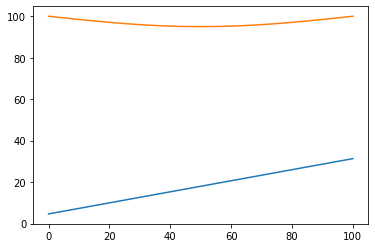

In [20]:
x1 = 5
x2 = 20 
y1 = 6
y2 = 10

x_int = scipy.optimize.fsolve(intersection_function, x2)
y_int = path_function(x_int)
print(x_int,y_int)
x = np.linspace(0,100,100)
plt.plot(x, path_function(x), zorder=1)
plt.plot(x, lakebed(x), zorder=1)

In [34]:
theta1 = 90
x1 = 1
y1 = 1
x2 = 2
y2 = 2


-1.633123935319537e+16

In [69]:
y=np.zeros(6)
preferred_depth - y

array([5., 5., 5., 5., 5., 5.])